In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

/data/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


cpu


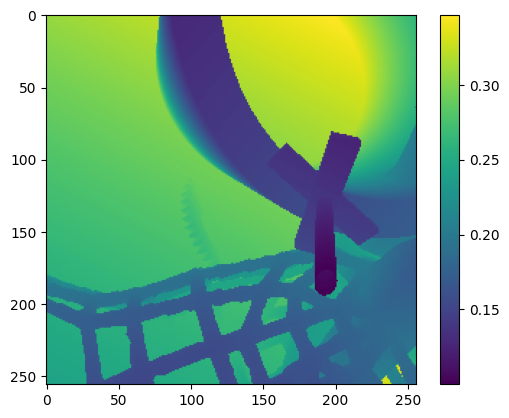

256 256
float16 float32
adaptive kernel size set to 11


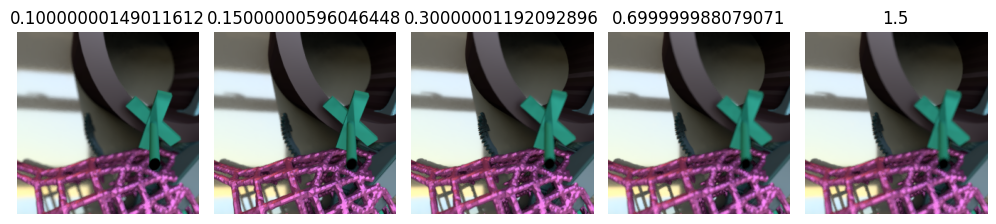

In [2]:
globals.init_DefocusNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

IMAGE_RANGE = 255.

# load data 
gt_dpt, defocus_stack = utils.load_single_sample_DefocusNet()
defocus_stack *= IMAGE_RANGE 

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape
print(width, height)
print(gt_dpt.dtype, defocus_stack.dtype)

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)


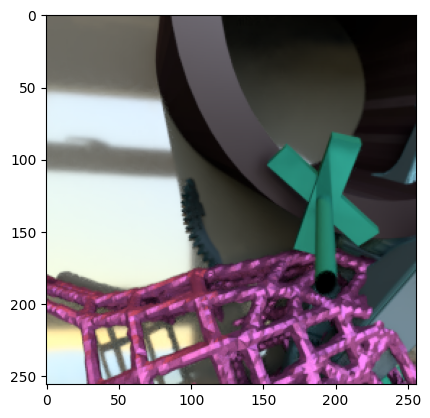

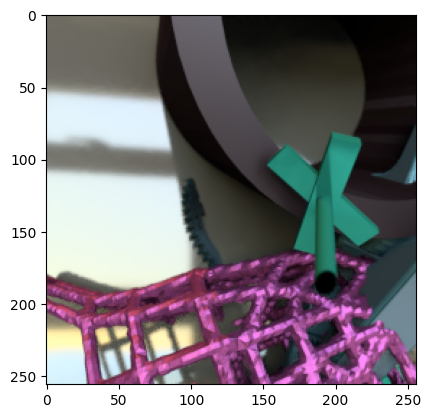

In [3]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05,
                                                     sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

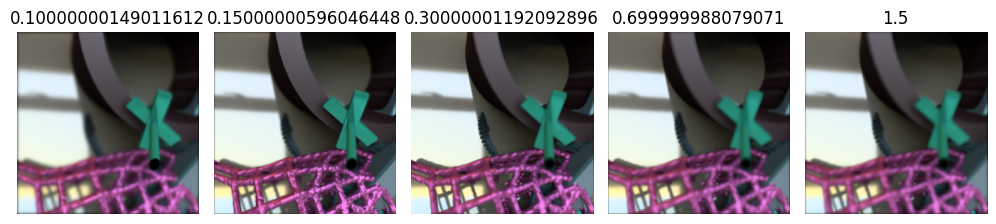

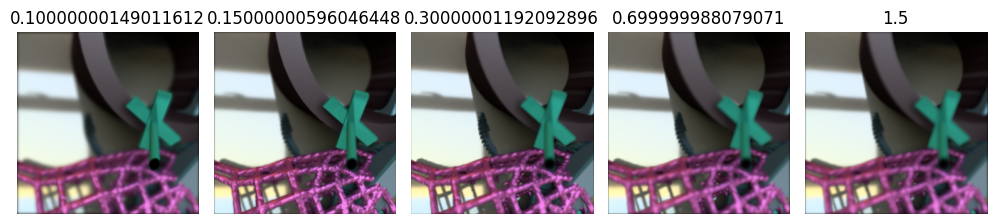

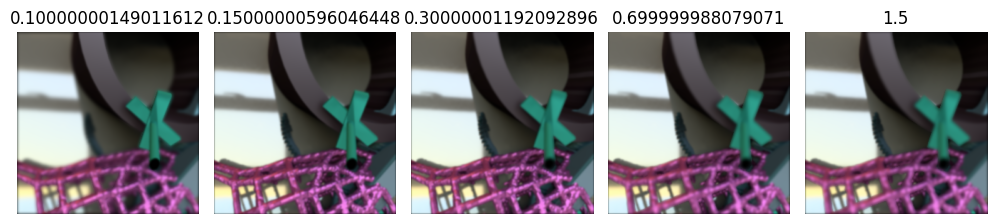

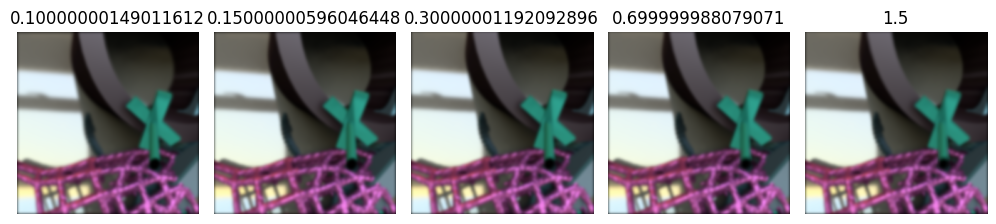

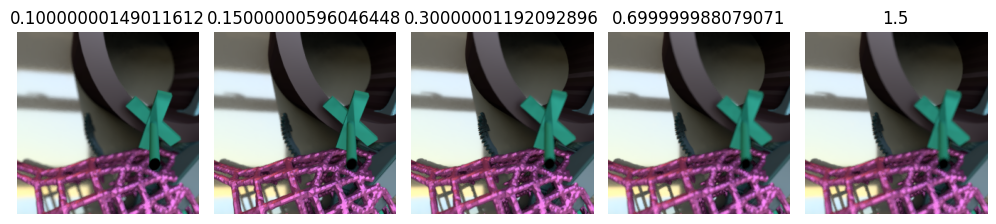

0 --> 2.3658203982590553e-05
0.5 --> 2.4971261874696124e-05
1 --> 2.97217609587265e-05
2 --> 5.2420522281927196e-05


In [4]:
# sanity check 

globals.thresh = 0
test_defocus_stack_none = forward_model.forward(gt_dpt, aif_init)
globals.thresh = 0.5
test_defocus_stack_05 = forward_model.forward(gt_dpt, aif_init)
globals.thresh = 1
test_defocus_stack_1 = forward_model.forward(gt_dpt, aif_init)
globals.thresh = 2
test_defocus_stack_2 = forward_model.forward(gt_dpt, aif_init)

utils.plot_single_stack(test_defocus_stack_none / IMAGE_RANGE, globals.Df)
utils.plot_single_stack(test_defocus_stack_05 / IMAGE_RANGE, globals.Df)
utils.plot_single_stack(test_defocus_stack_1 / IMAGE_RANGE, globals.Df)
utils.plot_single_stack(test_defocus_stack_2 / IMAGE_RANGE, globals.Df)
utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)

print('0 -->', np.mean(defocus_stack / IMAGE_RANGE - test_defocus_stack_none / IMAGE_RANGE)**2)
print('0.5 -->', np.mean(defocus_stack / IMAGE_RANGE - test_defocus_stack_05 / IMAGE_RANGE)**2)
print('1 -->', np.mean(defocus_stack / IMAGE_RANGE - test_defocus_stack_1 / IMAGE_RANGE)**2)
print('2 -->', np.mean(defocus_stack / IMAGE_RANGE - test_defocus_stack_2 / IMAGE_RANGE)**2)


Created experiment folder: /data/holly_jackson/experiments/defocus-net-000373_2025-10-22_01-38-10
Images in range [0-255]


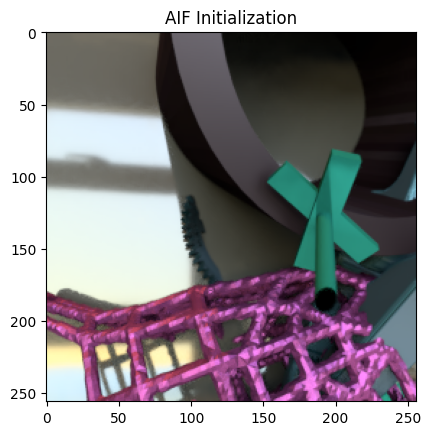

Iteration 0 



Grid search         : 100%|███████████████████| 100/100 [00:12<00:00,  8.12it/s]


GRID SEARCH DURATION 12.473724365234375


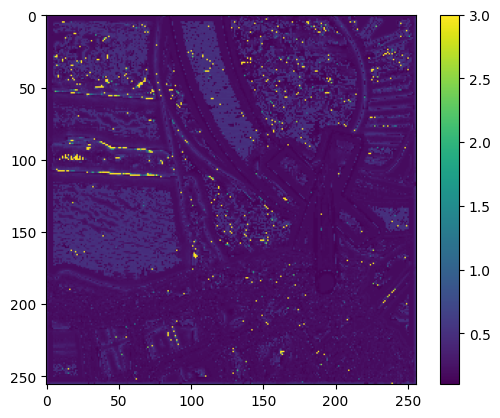


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 9.414842128753662


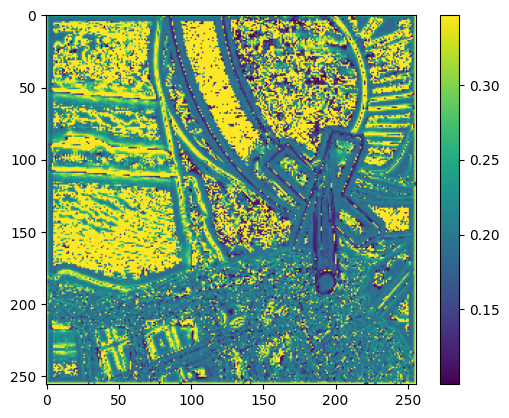

Loss: 56.338154 , TV: 14801.843

DPT result range: [ 0.10345756 , 2.9965425 ]


Bounded FISTA...


Optimizing: 100%|█████████████████████████████| 200/200 [01:34<00:00,  2.12it/s]


r1norm 6062.192 norm(x) 57526.105
FISTA duration 98.28226017951965

AIF result range: [ 0.0 , 255.0 ]
Loss: 37.385498 , TV: 3259657.8


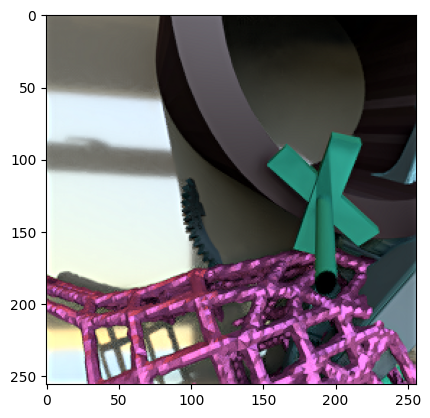

FULL ITER DURATION 122.78180241584778
ls_maxiter updated to 210


--------------------------



In [5]:
# -------------------
# COORDINATE DESCENT
# -------------------

globals.thresh = 0.5

dpt, aif, _, _ = coordinate_descent.coordinate_descent(defocus_stack,
        experiment_folder='/data/holly_jackson/experiments',
        show_plots=True, save_plots=False,
        experiment_name = 'defocus-net-000373', num_epochs = 1,
        # least_squares_first=True, depth_init=depth_init,
        least_squares_first = False, aif_init = aif_init,                                             
        k = 1, aif_method = 'fista',
        finite_differences = False, num_Z = 100, 
        ls_maxiter = 200, ls_maxiter_multiplier = 1.05, 
        min_Z = 0.1, max_Z = 3,
        vmin = gt_dpt.min(), vmax = gt_dpt.max(), verbose = True)


RMS 0.28947788
Rel 0.52488106
{'delta1': 0.378753662109375, 'delta2': 0.6889190673828125, 'delta3': 0.8770294189453125}


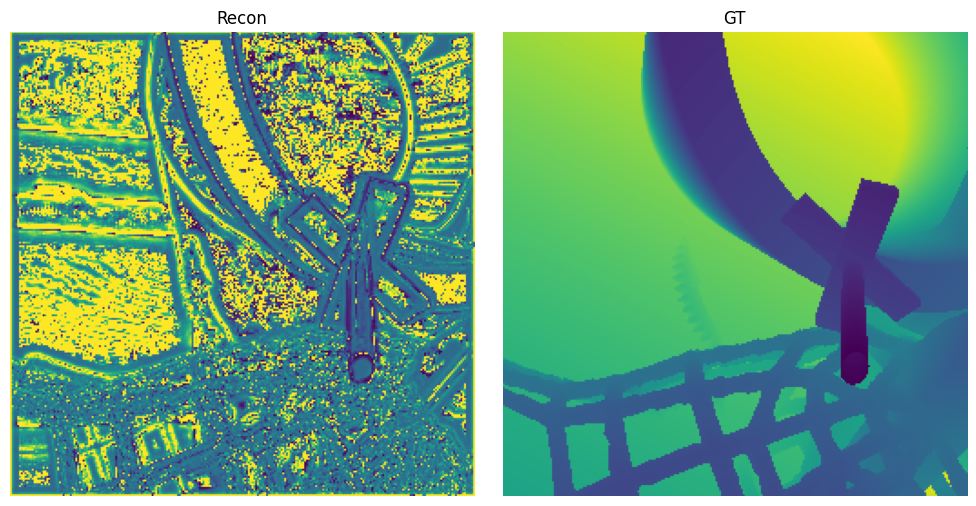

In [6]:
print('RMS', utils.compute_RMS(dpt, gt_dpt))
print('Rel', utils.compute_Rel(dpt, gt_dpt))
print(utils.compute_accuracy_metrics(dpt, gt_dpt))

utils.plot_compare_greyscale(dpt, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())


# todo: fista check if A @ x is quicker stacked or in loop

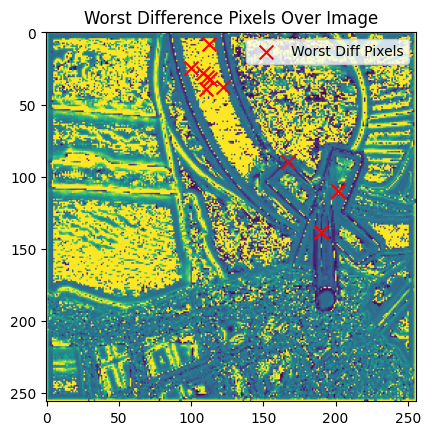

In [7]:
worst_coords = utils.get_worst_diff_pixels(dpt, gt_dpt, num_worst_pixels=10, vmin=gt_dpt.min(), vmax=gt_dpt.max())

k = 10  # top-k best (smallest diffs)

diff = np.abs(dpt - gt_dpt)
flat = diff.ravel()

# k smallest indices (unsorted), then sort them by value ascending
best_idx = np.argpartition(flat, k)[:k]
best_idx = best_idx[np.argsort(flat[best_idx])]

# 2D coordinates (row, col), sorted by increasing diff
rows, cols = np.unravel_index(best_idx, diff.shape)
best_coords = list(zip(rows, cols))

In [8]:
depth_maps, Z, k_min_indices, all_losses = section_search.grid_search_opt_k(
    aif, defocus_stack,
    indices = None, min_Z = 0.1, max_Z = 3, num_Z = 100, k = 1)

print(k_min_indices.shape)

Grid search         : 100%|███████████████████| 100/100 [00:12<00:00,  8.13it/s]


(256, 256, 1)


3 0.18787879 -0.038685203 -0.099193215


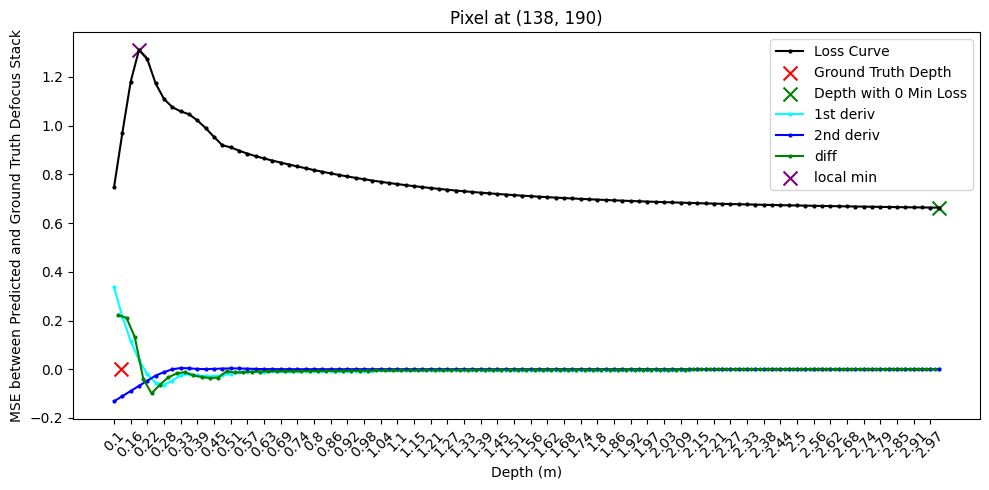

3 0.18787879 0.028986022 0.0019397736
14 0.510101 -0.0037267357 -0.005584821
19 0.65656567 0.0001770854 0.00048057735


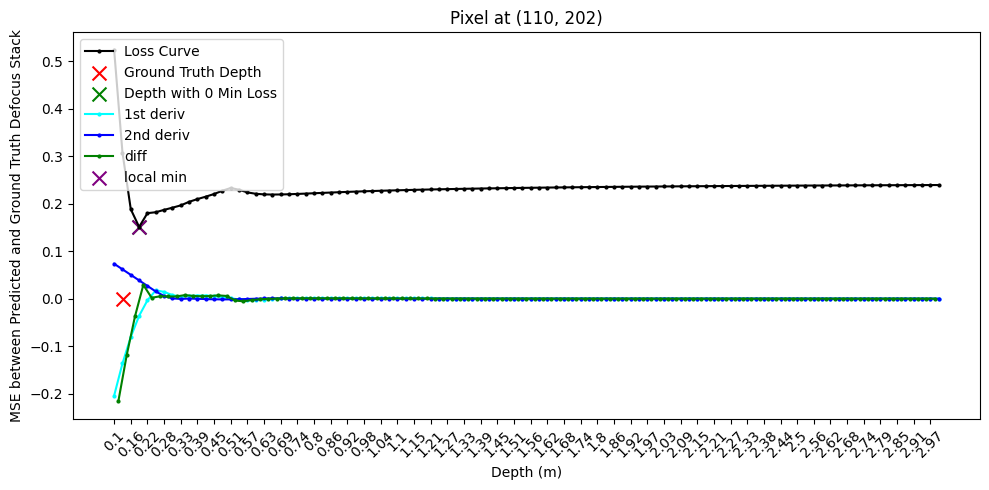

1 0.12929294 0.009489909 0.007290803
5 0.24646464 -0.0037409887 -0.0072253644


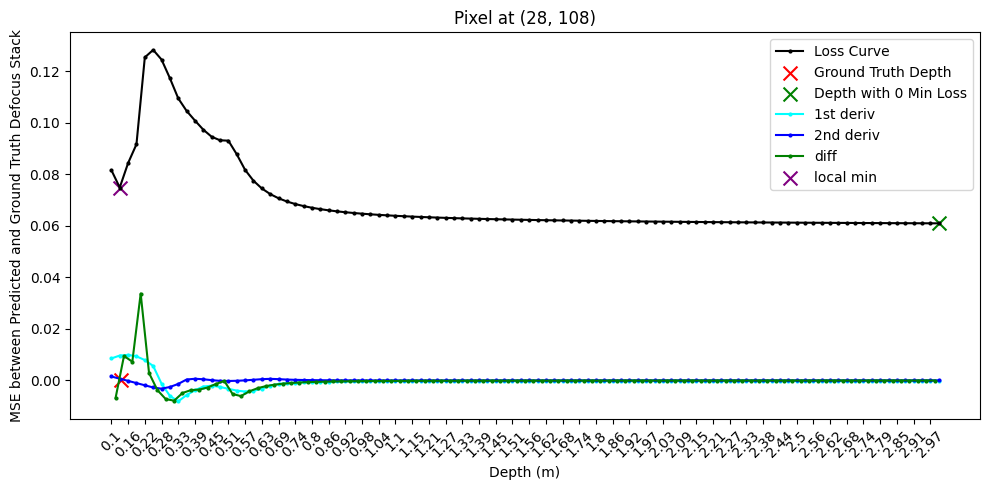

4 0.21717171 -0.00021226704 -0.008130521


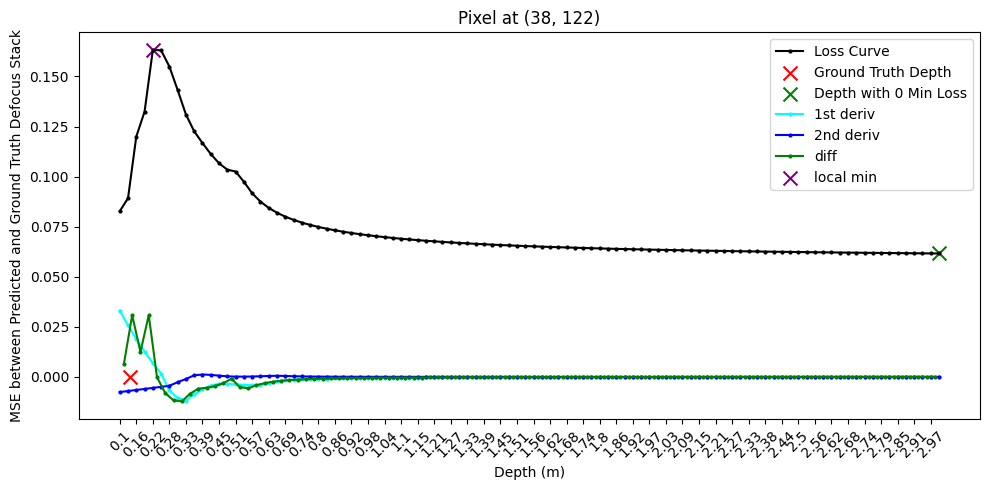

1 0.12929294 -3.0744805 -1.2425303
3 0.18787879 5.401436 0.62947464
5 0.24646464 -0.5324335 -1.1538582


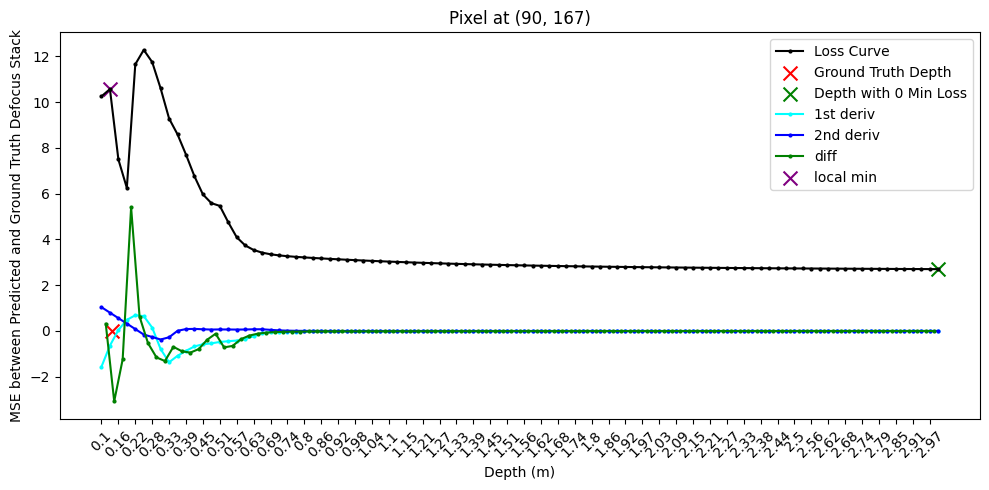

1 0.12929294 0.0074082017 0.007656969
5 0.24646464 -0.002939187 -0.005941987


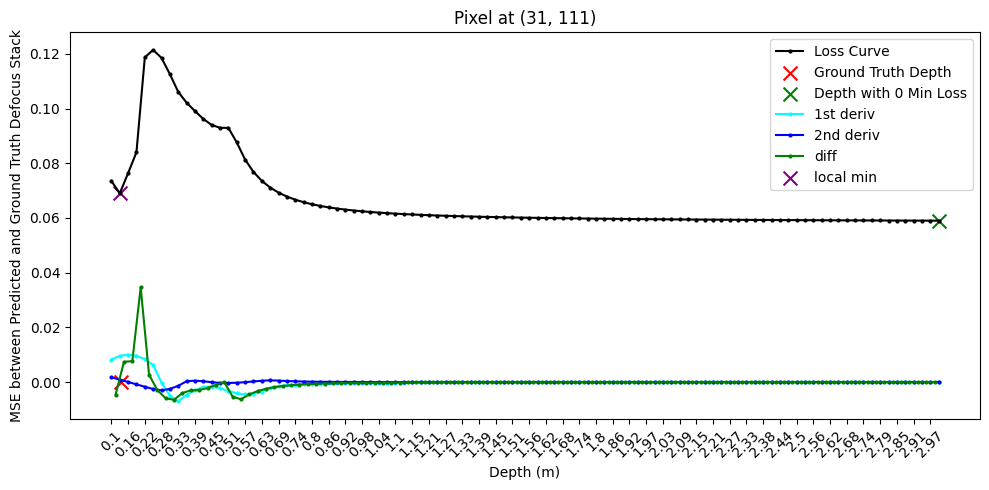

1 0.12929294 0.009241052 0.006047778
5 0.24646464 -0.003918484 -0.00758636
13 0.48080808 0.00010732561 -0.0053223446
14 0.510101 -0.0053223446 -0.006174661


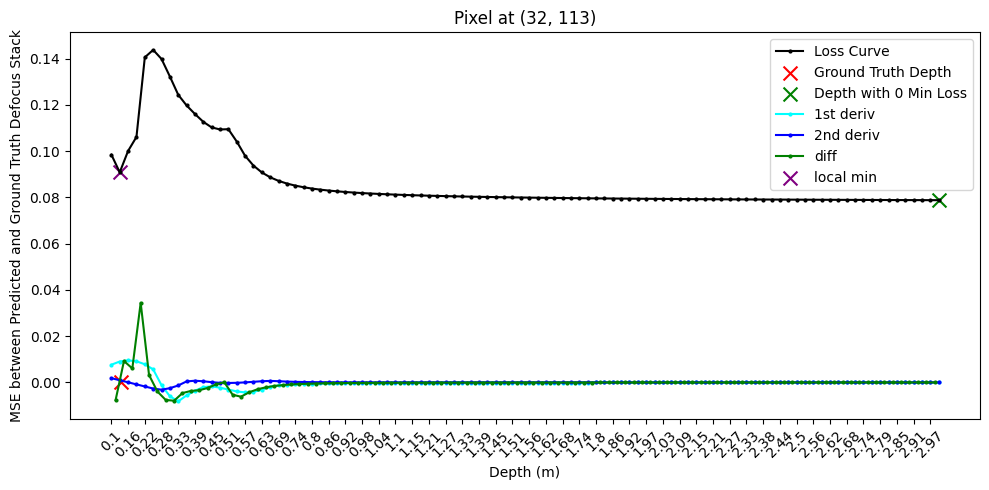

5 0.24646464 -0.0046491623 -0.007295534


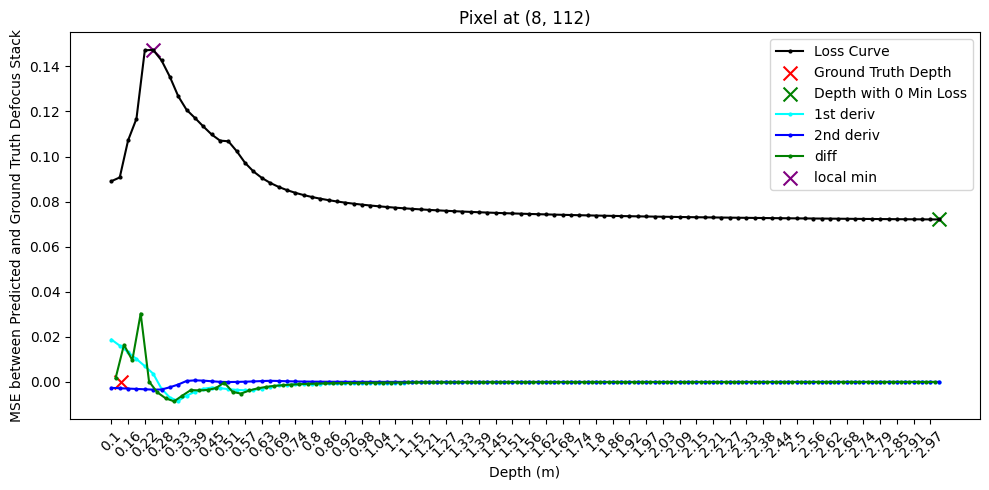

2 0.15858586 0.0059420466 0.028521687
4 0.21717171 -0.001530379 -0.003476955
13 0.48080808 0.00032813102 -0.0050422475
14 0.510101 -0.0050422475 -0.0061630383


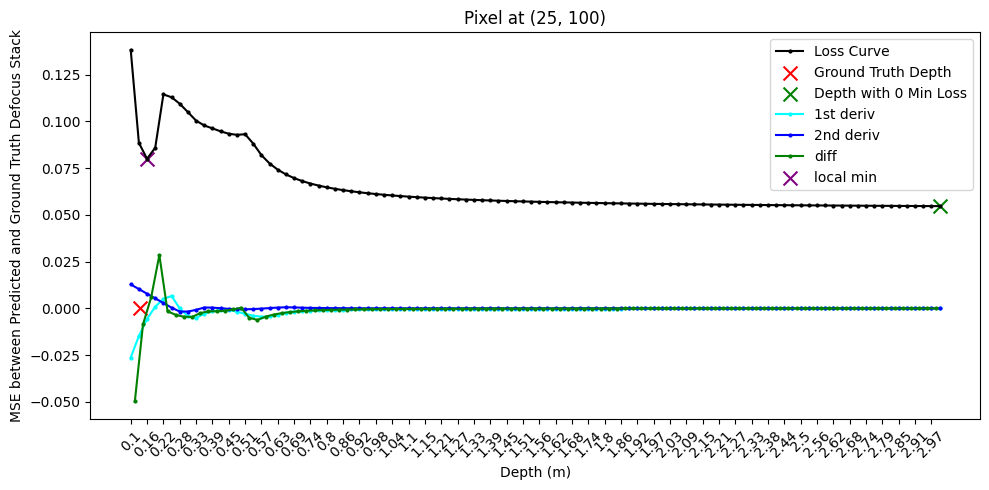

2 0.15858586 0.008578852 0.029964134
4 0.21717171 -0.0014534742 -0.005682647
12 0.45151514 2.5257468e-05 0.00036992133
14 0.510101 -0.0048654526 -0.006169483


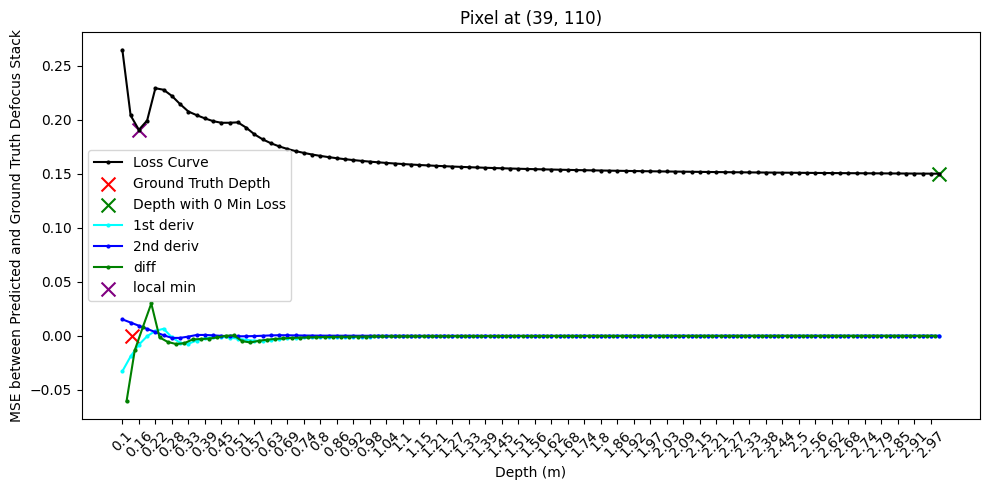

5 0.24646464 2.8246994 8.598236


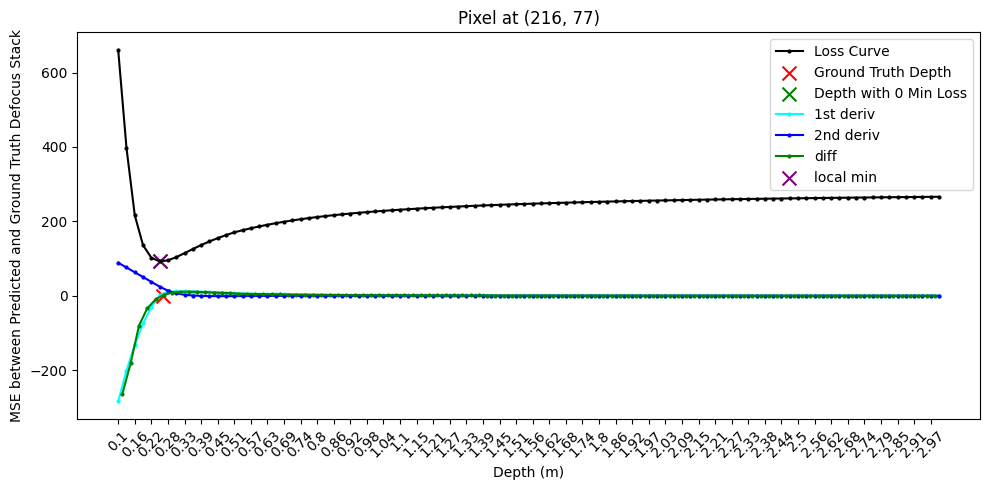

3 0.18787879 0.42757273 1.3631287


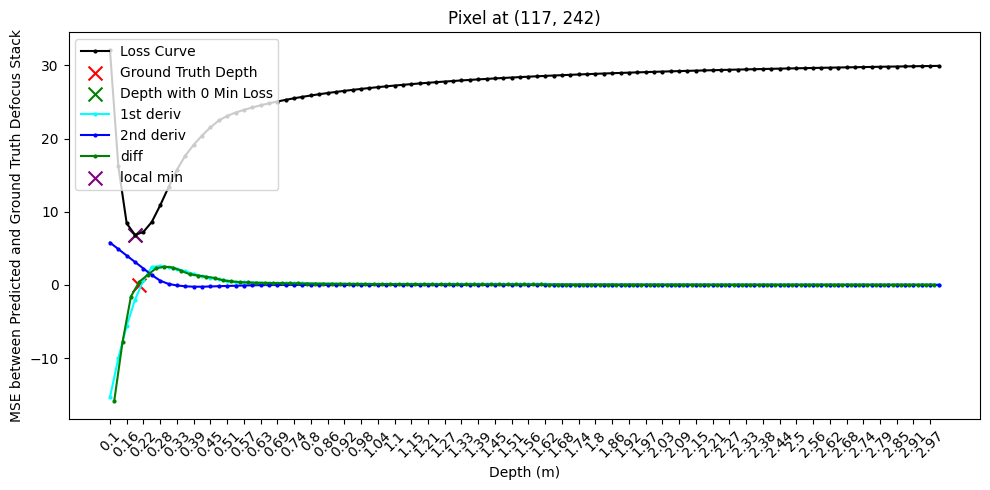

3 0.18787879 4.359215 9.137098
13 0.48080808 -0.13956451 -0.05154419
15 0.53939396 0.095687866 0.19849014


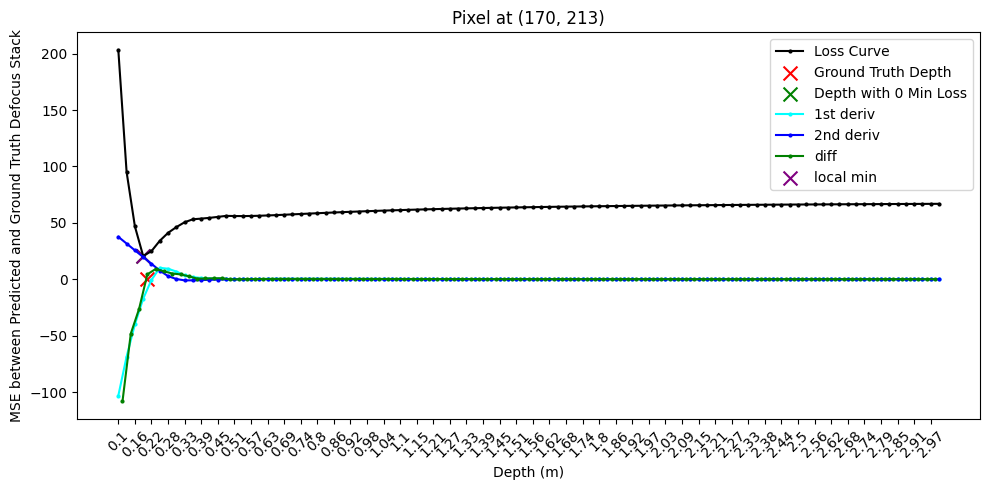

2 0.15858586 3.2186255 10.028145
14 0.510101 -0.23391724 -0.41034698
17 0.5979798 0.16993713 0.27682495


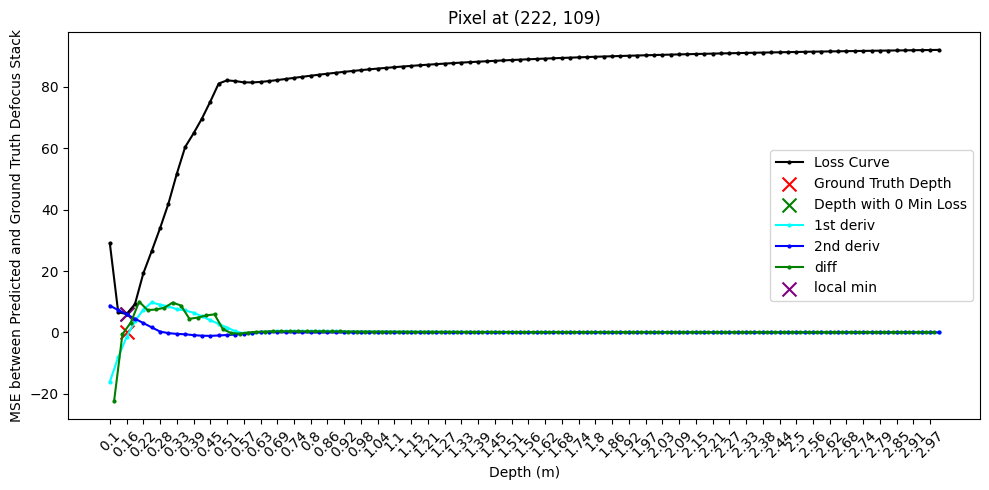

2 0.15858586 36.280987 190.5439
14 0.510101 -15.31604 -19.218323


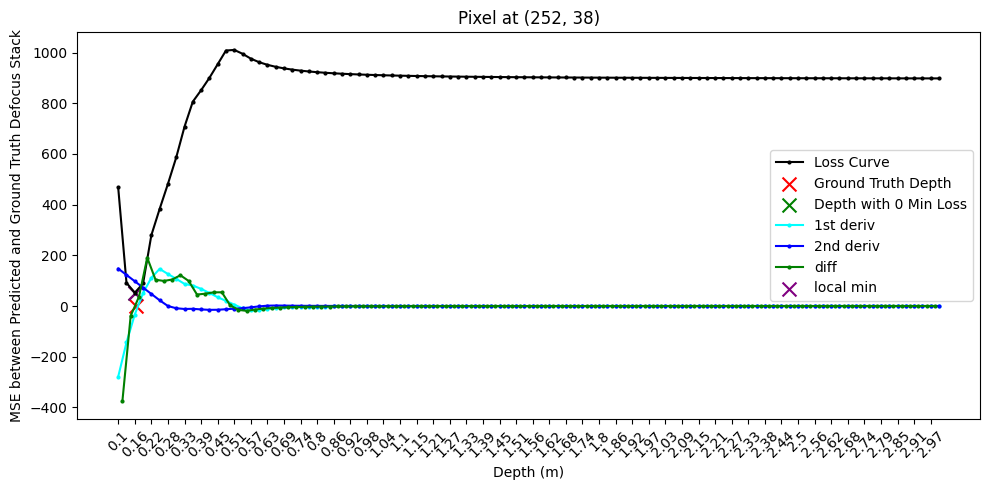

3 0.18787879 0.21010256 2.3497086
14 0.510101 -0.3316002 -0.31918144
17 0.5979798 0.031957626 0.11459923


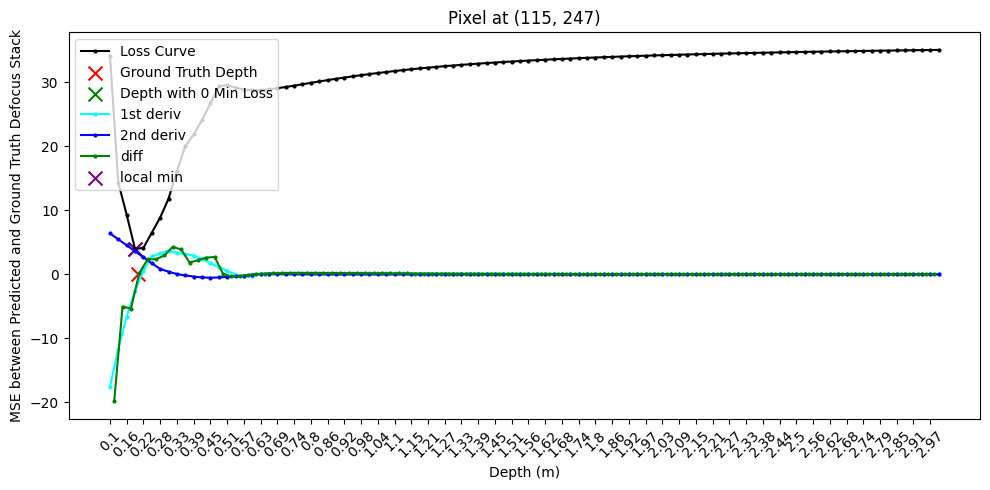

3 0.18787879 1.6963539 2.3636446


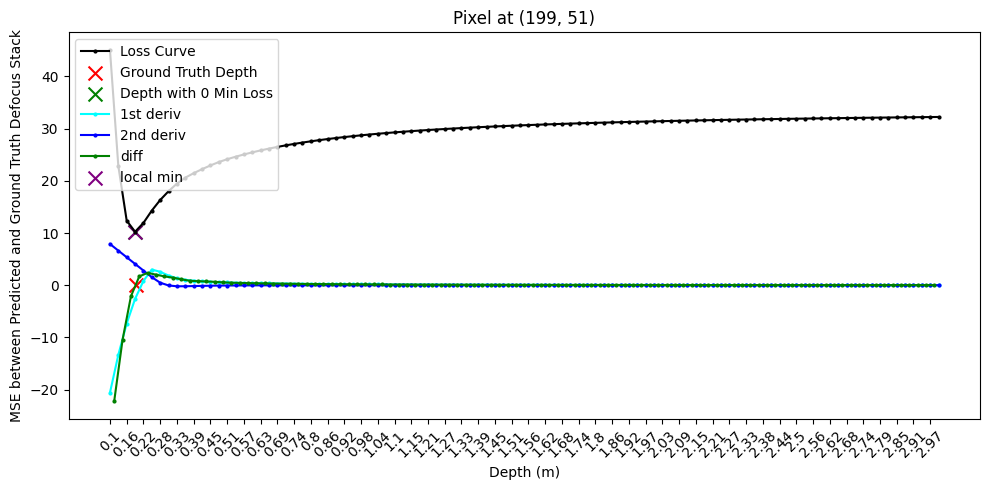

3 0.18787879 70.15799 37.69246
14 0.510101 -12.204498 -13.148712
20 0.6858586 0.5635376 1.0197449


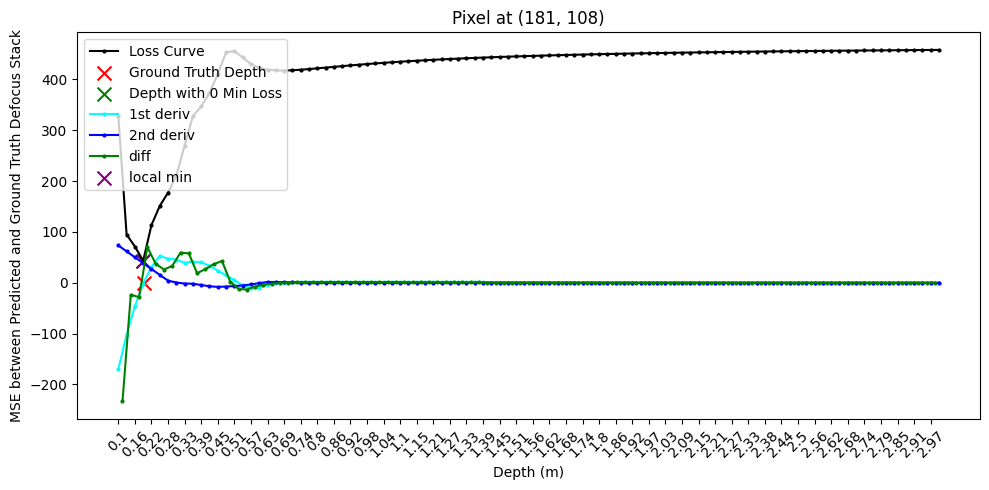

3 0.18787879 1.1852398 1.5674188
14 0.510101 -0.12578392 -0.11385155
16 0.56868684 0.013381958 0.07967949


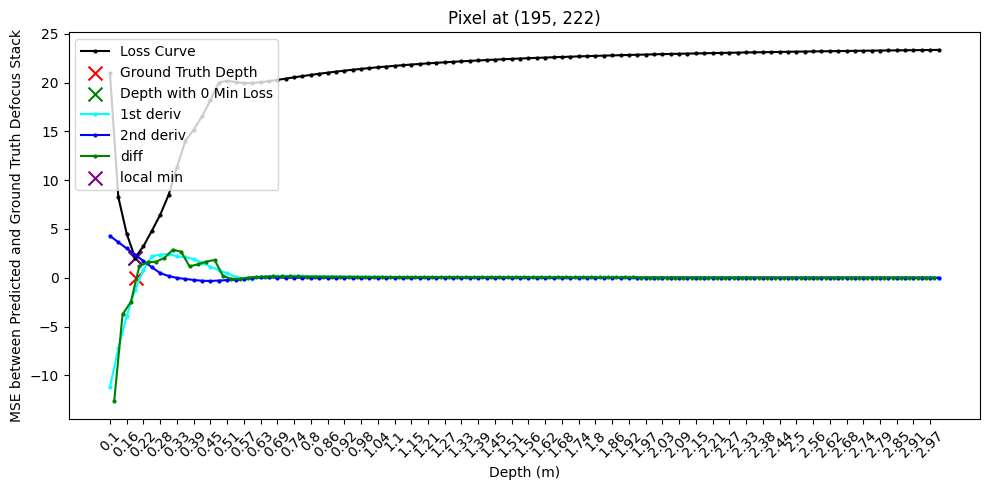

3 0.18787879 0.046609044 0.0697007


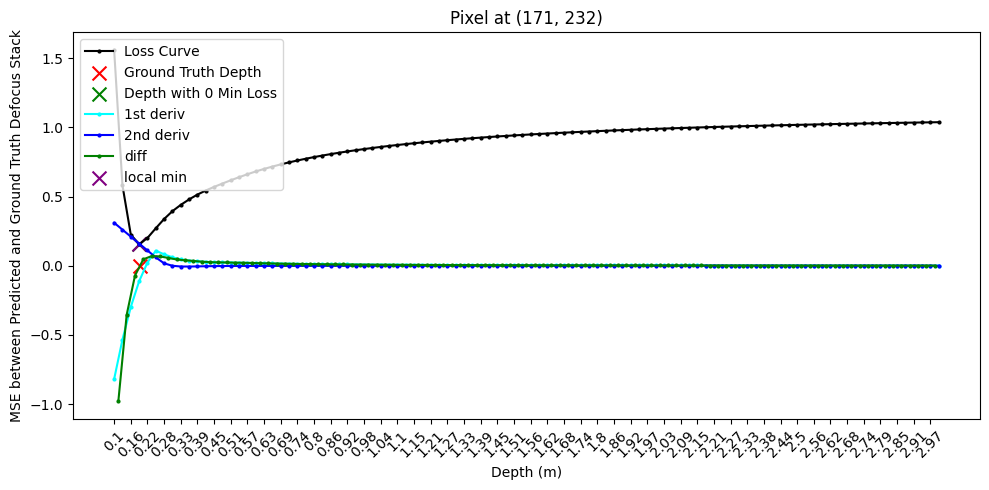

In [9]:
for i, j in worst_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt,
                                k_min_indices=k_min_indices[i,j])

for i, j in best_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt,
                                k_min_indices=k_min_indices[i,j])
    

In [10]:
# instead of min loss what if we found area with highest magnitude second derivative 


In [ ]:
def strongest_curvature_region(i, j, all_losses, window=11):
    window = int(window)
    if window < 1:
        raise ValueError("window must be >= 1")
    if window % 2 == 0:
        window += 1
        
    losses = all_losses[i, j]
    d2 = np.gradient(np.gradient(losses))

    kernel = np.ones(window) / window
    avg_d2 = np.convolve(d2, kernel, mode="valid")

    # region with most negative average curvature
    start_valid = (window - 1) // 2
    center_offset = int(np.argmin(avg_d2))
    idx_center_region = start_valid + center_offset
    
    return idx_center_region

for i, j in worst_coords:
    idx_max_point, idx_min_point = strongest_curvature_region(i, j, all_losses, Z)
    print(Z[idx_max_point], Z[idx_min_point])